[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/MLP.ipynb)

# Multilayer Perceptron (MLP)
Our goal here is to implement a two-layer neural network for binary classification, train it using gradient descent and use it to classify the Iris dataset.
Our model is
$$
\hat{y} = \sigma \left ( W \sigma \left ( V x \right ) \right)
$$
where we have $M$ hidden units and $D$ input features -- that is $w \in \mathbb{R}^{M}$, and $V \in \mathbb{R}^{M \times D}$. For simplicity here we do not include a bias parameter for each layer. Key to our implementation is the gradient calculation. We follow the notation used in the slides here.

In [ ]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

from IPython.core.debugger import set_trace
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold

# Data Preprocessing

In [ ]:
# packaging it all into a function
def preprocess_fashion_mnist():
  import random as rand
   
   
  (x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
  # print("\nx_train shape:", x_train.shape, " -- y_train shape", y_train.shape)
  # print("x_test shape", x_test.shape, " -- y_test shape", y_test.shape)
  mean_mat = np.mean(x_train, axis=0)
  # centering the data by removing the pixel wise mean from every pixel in every image
  x_train_centered = x_train - mean_mat
  x_test_centered = x_test - mean_mat
  # normalizing the grayscale values to values in interval [0,1]
  x_train_normalized = x_train_centered/255.0
  x_test_normalized = x_test_centered/255.0

  #finally, flattening the data
  x_train = np.reshape(x_train_normalized, (60000,784))
  x_test = np.reshape(x_test_normalized, (10000, 784))
  #converting the test data to one hot encodings
  y_train = keras.utils.to_categorical(y_train, num_classes=10)
  y_test = keras.utils.to_categorical(y_test, num_classes=10)
  
  return x_train[:10000], y_train[:10000], x_test, y_test
x_train, y_train, x_test, y_test = preprocess_fashion_mnist()

4431872/4422102 [==============================] - 0s 0us/step


# Model Implementation - SoftMax


**Activation functions**

In [ ]:
#activation functions
softmax1D = lambda z: np.exp(z)/float(sum(np.exp(z)))
softmax2D = lambda z: np.array([np.exp(i)/float(sum(np.exp(i))) for i in z])

# Logistic
logistic = lambda z: 1./ (1 + np.exp(-z))

# Tanh
tanh = lambda x: 2./ (1+np.exp(-2*x)) -1
tanh_grad = lambda x: 1 - np.square(2./ (1+np.exp(-2*x)) -1)

# Leaky ReLu
def leaky_relu(x):
  alpha = 0.1
  x=np.array(x).astype(float)
  np.putmask(x, x<0, alpha*x)
  return x

def leaky_relu_grad(x):
  alpha = 0.1
  x=np.array(x).astype(float)
  x[x>0]=1
  x[x<=0]=alpha
  return x

  
# ReLu
def relu(x):
  x=np.array(x).astype(float)
  np.putmask(x, x<0, 0)
  return x
  
def relu_grad(x):
  x=np.array(x).astype(float)
  x[x>0]=1
  x[x<=0]=0
  return x

Accuracy function

In [ ]:
def evaluate_acc(pred, truth):
  counter =0
  
  for i in range(len(pred)):
    maxVal = np.where(pred[i] == np.amax(pred[i]))
    counter += 1 if maxVal == np.where(truth[i]==1) else 0
  return counter * 100.0 / float(len(pred))
  

## Model - ReLu

In [ ]:
class MLPRelu:
    
    def __init__(self, M = 128, num_classes = 10):
        self.M = M
        self.num_classes = num_classes
        
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        def gradient(x, y, params):
            v1, v2, w = params # v1.shape = (D, M), v2.shape = (M, M) w.shape = (M)
            q1 = np.dot(x, v1) 
            z1 = relu(q1) #N x M
            q2 = np.dot(z1, v2) # N
            z2 = relu(q2)
            yh = softmax2D(np.dot(z2, w))#N
            acc = evaluate_acc(yh,y)
            # print('yShape=', y.shape)

            ## Backpropagation
            ## 1st layer
            dy = yh - y #N
            dw = np.dot(z2.T, dy)/N #M  
            ## 2nd Layer                  
            # dz = np.dot(dy.T, w)
            dz2 = np.dot(dy, w.numpy().T) #N x M                   = (yh-y)*w from slide 16
            dv2 = np.dot(z1.T, dz2 * relu_grad(q2))/N #D x M   = (yh-y)*w*(activation)'*x
            ## 3rd Layer
            dz1 = np.dot(dz2, v2.numpy().T) #N x M                   = (yh-y)*w from slide 16
            dv1 = np.dot(x.T, dz1 * relu_grad(q1))/N #D x M   = (yh-y)*w*(activation)'*x
            dparams = [dv1, dv2, dw]
            return dparams, acc
        
        # w = np.random.randn(self.M) * .01
        # v = np.random.randn(D,self.M) * .01
        initializer = keras.initializers.GlorotNormal()
        w = initializer(shape=(self.M, self.num_classes))
        v2 = initializer(shape=(self.M, self.M))
        v1 = initializer(shape=(D, self.M))
        
        params0 = [v1, v2,w]
        self.params, batch_acc = optimizer.run_mini_batch(gradient, x, y, params0)#optimizer.run_mini_batch(gradient, x, y, params0) #
        return self, batch_acc
    
    def predict(self, x):
        v1, v2, w = self.params
        z1 = relu(np.dot(x, v1)) #N x M
        z2 = relu(np.dot(z1, v2))
        yh = softmax2D(np.dot(z2, w))#N
        return yh

# Model - Leaky ReLu

In [ ]:
class MLPLeakyRelu:
    
    def __init__(self, M = 128, num_classes = 10):
        self.M = M
        self.num_classes = num_classes
        
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        def gradient(x, y, params):
            # print('v1=',params[0].shape)
            # print('v2=',params[1].shape)
            # print('w=',params[2].shape)
            # print('x=',x.shape)
            v1, v2, w = params # v1.shape = (D, M), v2.shape = (M, M) w.shape = (M)
            q1 = np.dot(x, v1) 
            z1 = leaky_relu(q1) #N x M
            # print('q1=',q1.shape)   
            # print('z1=',z1.shape)

            q2 = np.dot(z1, v2) # N
            z2 = leaky_relu(q2)
            # print("z2=", z2.shape)

            # print("np.dot(z, w)=",np.dot(z, w).shape)
            yh = softmax2D(np.dot(z2, w))#N
            # print("yhS=",yh.shape)
            # print("yh=", yh[:10,:])
            # #get accuracy based on predictions
            # print(evaluate_acc(yh,y))
            # print('yShape=', y.shape)

            ## Backpropagation
            
            

            ## 1st layer
            dy = yh - y #N
            dw = np.dot(z2.T, dy)/N #M  
            # print("dh=",dy.shape)
            # print("dw=", dw.shape)    # = (yh-y)*z
            
            
            ## 2nd Layer                  
            # dz = np.dot(dy.T, w)
            dz2 = np.dot(dy, w.numpy().T) #N x M                   = (yh-y)*w from slide 16
            
            #in the below line, dz * z * (1-v) is element wise operation, not matrix multiplication
            # temp = dz2 * relu_grad(q) #(1024,128) (32,128)
            dv2 = np.dot(z1.T, dz2 * leaky_relu_grad(q2))/N #D x M   = (yh-y)*w*(activation)'*x
            # print("dz2=",dz2.shape)
            # print("dv2=", dv2.shape)

            ## 3rd Layer
            dz1 = np.dot(dz2, v2.numpy().T) #N x M                   = (yh-y)*w from slide 16
            dv1 = np.dot(x.T, dz1 * leaky_relu_grad(q1))/N #D x M   = (yh-y)*w*(activation)'*x
            # print("dz1=",dz2.shape)
            # print("dv1=", dv1.shape)


            dparams = [dv1, dv2, dw]
            # print(dparams)
            # print("yh shape:",len(yh[0]))
            return dparams
        
        # w = np.random.randn(self.M) * .01
        # v = np.random.randn(D,self.M) * .01
        initializer = keras.initializers.GlorotNormal()
        w = initializer(shape=(self.M, self.num_classes))
        v2 = initializer(shape=(self.M, self.M))
        v1 = initializer(shape=(D, self.M))
        
        params0 = [v1, v2,w]
        self.params = optimizer.run_mini_batch(gradient, x, y, params0) #optimizer.run(gradient, x, y, params0)#
        return self
    
    def predict(self, x):
        v1, v2, w = self.params
        z1 = relu(np.dot(x, v1)) #N x M
        z2 = relu(np.dot(z1, v2))
        yh = softmax2D(np.dot(z2, w))#N
        return yh

# Model - Tanh

In [ ]:
class MLPTanh:
    
    def __init__(self, M = 128, num_classes = 10):
        self.M = M
        self.num_classes = num_classes
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        def gradient(x, y, params):
            # print('v1=',params[0].shape)
            # print('v2=',params[1].shape)
            # print('w=',params[2].shape)
            # print('x=',x.shape)
            v1, v2, w = params # v1.shape = (D, M), v2.shape = (M, M) w.shape = (M)
            q1 = np.dot(x, v1) 
            z1 = tanh(q1) #N x M
            # print('q1=',q1.shape)   
            # print('z1=',z1.shape)

            q2 = np.dot(z1, v2) # N
            z2 = tanh(q2)
            # print("z2=", z2.shape)

            # print("np.dot(z, w)=",np.dot(z, w).shape)
            yh = softmax2D(np.dot(z2, w))#N
            # print("yhS=",yh.shape)
            # print("yh=", yh[:10,:])
            # #get accuracy based on predictions
            # print(evaluate_acc(yh,y))
            # print('yShape=', y.shape)

            ## Backpropagation
            
            

            ## 1st layer
            dy = yh - y #N
            dw = np.dot(z2.T, dy)/N #M  
            # print("dh=",dy.shape)
            # print("dw=", dw.shape)    # = (yh-y)*z
            
            
            ## 2nd Layer                  
            # dz = np.dot(dy.T, w)
            dz2 = np.dot(dy, w.numpy().T) #N x M                   = (yh-y)*w from slide 16
            
            #in the below line, dz * z * (1-v) is element wise operation, not matrix multiplication
            # temp = dz2 * relu_grad(q) #(1024,128) (32,128)
            dv2 = np.dot(z1.T, dz2 * tanh_grad(q2))/N #D x M   = (yh-y)*w*(activation)'*x
            # print("dz2=",dz2.shape)
            # print("dv2=", dv2.shape)

            ## 3rd Layer
            dz1 = np.dot(dz2, v2.numpy().T) #N x M                   = (yh-y)*w from slide 16
            dv1 = np.dot(x.T, dz1 * tanh_grad(q1))/N #D x M   = (yh-y)*w*(activation)'*x
            # print("dz1=",dz2.shape)
            # print("dv1=", dv1.shape)


            dparams = [dv1, dv2, dw]
            # print(dparams)
            # print("yh shape:",len(yh[0]))
            return dparams
        
        # w = np.random.randn(self.M) * .01
        # v = np.random.randn(D,self.M) * .01
        initializer = keras.initializers.GlorotNormal()
        w = initializer(shape=(self.M, self.num_classes))
        v2 = initializer(shape=(self.M, self.M))
        v1 = initializer(shape=(D, self.M))
        
        params0 = [v1, v2,w]
        self.params = optimizer.run_mini_batch(gradient, x, y, params0) #optimizer.run(gradient, x, y, params0)#
        return self
    
    def predict(self, x):
        v1, v2, w = self.params
        z1 = relu(np.dot(x, v1)) #N x M
        z2 = relu(np.dot(z1, v2))
        yh = softmax2D(np.dot(z2, w))#N
        return yh

# Model Implementation - Logistic

In [ ]:
q= (32, 128) # N x M
z= (32, 128) # N x M
yh= (32,) # N
dh= (32, 32) # N x N
dw= (128, 32) # M x N
dz= (1024, 128) # ? x M

In [ ]:
logistic = lambda z: 1./ (1 + np.exp(-z))

class MLP_sig:
    
    def __init__(self, M = 64):
        self.M = M
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        def gradient(x, y, params):
            v, w = params
            z = logistic(np.dot(x, v)) #N x M
            yh = logistic(np.dot(z, w))#N
            # print("Train acc:", evaluate_acc_sig(yh,y))
            dy = yh - y #N
            dw = np.dot(z.T, dy)/N #M
            dz = np.outer(dy, w) #N x M
            dv = np.dot(x.T, dz * z * (1 - z))/N #D x M
            dparams = [dv, dw]
            return dparams
        
        w = np.random.randn(self.M) * .01
        v = np.random.randn(D,self.M) * .01
        params0 = [v,w]
        self.params = optimizer.run_mini_batch(gradient, x, y, params0)
        return self
    
    def predict(self, x):
        v, w = self.params
        z = logistic(np.dot(x, v)) #N x M
        yh = logistic(np.dot(z, w))#N
        return yh

def evaluate_acc_sig(yh,y):
  assert( len(yh) == len(y))
  counter =0
  for i in range(len(yh)):
    counter += 1 if yh[i] == y[i] else 0
  return counter * 100.0 / float(len(yh))

# Batch Implementation

In the implementation above we have used a list data structure to maintain model parameters and their gradients. Below I have modified the `GradientDescent` class to also work with a list of parameters. One sournce of confusion in the above implementation is the gradient calculation. While in the slides during the lectures 
we calculated the partial derivative for individual parameters, here, we use vector and matrix operations to calculate the derivative for *all* parameters. 

In [ ]:
def mini_batcher(x, y, mini_batch_size):
  zipped = np.hstack( (x, y ) )
  np.random.shuffle(zipped)
  x_batches, y_batches = [], []
  mini_batches = []
  batch_num = x.shape[0] // mini_batch_size 
  for i in range(batch_num):
    x_batch = zipped[ i * mini_batch_size : (i+1) * mini_batch_size, :-10]
    y_batch = zipped[ i * mini_batch_size : (i+1) * mini_batch_size, -10:]
    mini_batches.append( ( x_batch, y_batch) )
  if x.shape[0] % mini_batch_size != 0:
    x_batch = zipped[ batch_num * mini_batch_size :, :-10]
    y_batch = zipped[ batch_num * mini_batch_size :, -10:]
    mini_batches.append( ( x_batch, y_batch ) )
    
  return mini_batches

# Gradient Descent 

---



In [ ]:
class GradientDescent:
    
    def __init__(self, learning_rate=.002, max_iters=1000, epsilon=1e-4, batch_size=32):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        
    def run(self, gradient_fn, x, y, params):
        norms = np.array([np.inf])
        t = 1
        while np.any(norms > self.epsilon) and t < self.max_iters:
            grad = gradient_fn(x, y, params)
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        print(t)
        return params
    
    

    def run_mini_batch(self, gradient_fn, x, y, params, batch_size=32):
        norms = np.array([np.inf])
        t=1
        temp_acc,batch_acc, chunk= [], [], []
        mini_batches = mini_batcher(x, y, batch_size)
        # print(len(mini_batches))
        batch_index = 0

        while np.any(norms > self.epsilon) and t < self.max_iters*len(mini_batches):
            
            if(batch_index == batch_size):
              mini_batches = mini_batcher(x, y, batch_size)
              batch_index = 0
            batch_index +=1

            x_temp, y_temp = mini_batches[t % ( len(mini_batches)-1 ) ][0], mini_batches[t % ( len(mini_batches)-1 ) ][1]
            grad, temp_acc = gradient_fn(x_temp, y_temp, params)
            chunk.append(temp_acc)
            if t % 10000 == 0:
              print(f"Epoch{t}:{temp_acc}%")
            
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            if t%len(mini_batches) == 2:
              batch_acc.append(np.mean(chunk))
              chunk = []
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        return params, batch_acc

# MNIST DataSet

In [ ]:
model1 = MLPRelu(M=128, num_classes=10)
optimizer = GradientDescent(learning_rate=.002)
y_pred1, batch_acc = model1.fit(x_train[:10000], y_train[:10000], optimizer)

Epoch10000:21.875%
Epoch20000:25.0%
Epoch30000:28.125%
Epoch40000:37.5%
Epoch50000:34.375%
Epoch60000:43.75%
Epoch70000:37.5%
Epoch80000:40.625%
Epoch90000:46.875%
Epoch100000:62.5%
Epoch110000:46.875%
Epoch120000:50.0%
Epoch130000:59.375%
Epoch140000:53.125%
Epoch150000:56.25%
Epoch160000:59.375%
Epoch170000:65.625%
Epoch180000:75.0%
Epoch190000:53.125%
Epoch200000:53.125%
Epoch210000:78.125%
Epoch220000:62.5%
Epoch230000:68.75%
Epoch240000:75.0%
Epoch250000:59.375%
Epoch260000:65.625%
Epoch270000:81.25%
Epoch280000:62.5%
Epoch290000:68.75%
Epoch300000:71.875%
Epoch310000:65.625%


No handles with labels found to put in legend.


Number of full training batch iterations: 1000
Accuracies per training batch:
6.25
7.118610223642173
7.527955271565495
6.928913738019169
7.577875399361022
7.617811501597444
7.75758785942492
8.446485623003195
8.496405750798722
8.905750798722044
9.205271565495208
9.544728434504792
9.48482428115016
9.914137380191693
10.083865814696486
9.9241214057508
10.782747603833865
10.363418530351439
11.601437699680512
11.421725239616613
11.601437699680512
11.940894568690096
12.010782747603834
11.441693290734824
12.210463258785943
12.26038338658147
13.588258785942491
13.498402555910543
13.728035143769969
13.757987220447284
13.76797124600639
14.13738019169329
14.83626198083067
14.936102236421725
14.886182108626198
15.64496805111821
15.944488817891374
15.545127795527156
16.234025559105433
16.21405750798722
17.20247603833866
16.333865814696484
17.392172523961662
18.2008785942492
17.781549520766774
18.62020766773163
18.89976038338658
18.96964856230032
19.788338658146966
19.728434504792332
19.5487220447284

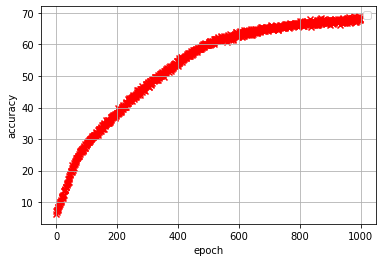

68.04


In [ ]:
y_test_pred1 = model1.predict(x_test)

print("Number of full training batch iterations:",len(batch_acc))
print("Accuracies per training batch:")
for i in batch_acc:
  print(i)
print("---------")
fig, ax = plt.subplots()
ax.scatter(range(len(batch_acc)), batch_acc, c='r', marker='x')
ax.legend()
ax.grid(True)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
print(evaluate_acc(y_test_pred1, y_test))

In [ ]:
evaluate_acc(y_test_pred1, y_test)

68.04